# Kaggle Match Outcome Prediction in Football

The goal of this project is to predict match outcomes of European football matches more accurately than bookkeepers, thereby beating the odds and to, in the end, generate a positive return on investment. Based on the dataset provided on kaggle.com that includes basic match data, FIFA player statistics and bookkeeper data, I built a model to predict the probability of each match outcome – win, draw, or defeat.

https://www.kaggle.com/hugomathien/soccer

## Import tables as dataframes

In [3]:
import sqlite3
import pandas as pd
# Create your connection.
cnx = sqlite3.connect('database.sqlite')

query_matches = """SELECT 
    id, date, match_api_id, 
    home_team_api_id, away_team_api_id, 
    -- (home_team_goal - away_team_goal) as goal_diff,
    CASE 
        WHEN home_team_goal > away_team_goal THEN 'H'
        WHEN home_team_goal < away_team_goal THEN 'A' 
        ELSE 'D'
        END as win_lose_draw,
    B365H, B365D, B365A, BWH, BWD, BWA, IWH, IWD, IWA, LBH, LBD, LBA
    -- ,  WHH, WHD, WHA, SJH, SJD, SJA, VCH, VCD, VCA, GBH, GBD, GBA, BSH, BSD, BSA
    FROM Match;
""" 

query_team_attributes = """SELECT
id, team_api_id, date, buildUpPlaySpeed, buildUpPlayPassing, chanceCreationPassing, chanceCreationCrossing, chanceCreationShooting, defencePressure, defenceAggression, defenceTeamWidth
FROM Team_Attributes;
"""

df = pd.read_sql_query(query_matches, cnx)
ta_df = pd.read_sql_query(query_team_attributes, cnx)

## Check Match table and remove null values

In [4]:
df.head()

,id,date,match_api_id,home_team_api_id,away_team_api_id,win_lose_draw,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA
0,1,2008-08-17 00:00:00,492473,9987,9993,D,1.73,3.40,5.00,1.75,3.35,4.20,1.85,3.2,3.5,1.80,3.3,3.75
1,2,2008-08-16 00:00:00,492474,10000,9994,D,1.95,3.20,3.60,1.80,3.30,3.95,1.90,3.2,3.5,1.90,3.2,3.50
2,3,2008-08-16 00:00:00,492475,9984,8635,A,2.38,3.30,2.75,2.40,3.30,2.55,2.60,3.1,2.3,2.50,3.2,2.50
3,4,2008-08-17 00:00:00,492476,9991,9998,H,1.44,3.75,7.50,1.40,4.00,6.80,1.40,3.9,6.0,1.44,3.6,6.50
4,5,2008-08-16 00:00:00,492477,7947,9985,A,5.00,3.50,1.65,5.00,3.50,1.60,4.00,3.3,1.7,4.00,3.4,1.72


In [38]:
df.describe()

,id,match_api_id,home_team_api_id,away_team_api_id,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,season
count,22467.000000,2.246700e+04,22467.000000,22467.000000,22467.000000,22467.000000,22467.000000,22467.000000,22467.000000,22467.000000,22467.000000,22467.000000,22467.000000,22467.000000,22467.000000,22467.000000,22467.000000
mean,11912.720790,1.195675e+06,10171.904927,10158.790715,2.628185,3.841820,4.665438,2.558916,3.748806,4.400137,2.467622,3.609387,4.149677,2.536204,3.713430,4.387509,2012.496818
std,7260.502926,4.966765e+05,14387.242333,14278.876876,1.794432,1.119239,3.736650,1.638415,1.034887,3.296818,1.445205,0.802459,2.858153,1.641795,1.004468,3.402633,2.309149
min,1.000000,4.831290e+05,1773.000000,1773.000000,1.040000,1.530000,1.080000,1.030000,1.650000,1.100000,1.050000,1.500000,1.100000,1.040000,1.440000,1.100000,2009.000000
25%,5666.500000,7.053870e+05,8530.000000,8530.000000,1.670000,3.300000,2.500000,1.650000,3.200000,2.500000,1.650000,3.200000,2.500000,1.670000,3.200000,2.500000,2010.000000
50%,11323.000000,1.083380e+06,8722.000000,8722.000000,2.100000,3.500000,3.500000,2.100000,3.400000,3.400000,2.100000,3.300000,3.300000,2.100000,3.400000,3.300000,2012.000000
75%,18912.500000,1.709854e+06,9905.000000,9905.000000,2.800000,4.000000,5.250000,2.750000,3.800000,5.000000,2.600000,3.700000,4.600000,2.700000,3.750000,5.000000,2015.000000
max,24557.000000,2.216672e+06,274581.000000,274581.000000,26.000000,17.000000,51.000000,34.000000,19.500000,51.000000,20.000000,11.000000,25.000000,26.000000,19.000000,51.000000,2016.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                25979 non-null  int64  
 1   date              25979 non-null  object 
 2   match_api_id      25979 non-null  int64  
 3   home_team_api_id  25979 non-null  int64  
 4   away_team_api_id  25979 non-null  int64  
 5   win_lose_draw     25979 non-null  object 
 6   B365H             22592 non-null  float64
 7   B365D             22592 non-null  float64
 8   B365A             22592 non-null  float64
 9   BWH               22575 non-null  float64
 10  BWD               22575 non-null  float64
 11  BWA               22575 non-null  float64
 12  IWH               22520 non-null  float64
 13  IWD               22520 non-null  float64
 14  IWA               22520 non-null  float64
 15  LBH               22556 non-null  float64
 16  LBD               22556 non-null  float6

In [7]:
df.isnull().sum()

id                     0
date                   0
match_api_id           0
home_team_api_id       0
away_team_api_id       0
win_lose_draw          0
B365H               3387
B365D               3387
B365A               3387
BWH                 3404
BWD                 3404
BWA                 3404
IWH                 3459
IWD                 3459
IWA                 3459
LBH                 3423
LBD                 3423
LBA                 3423
dtype: int64

In [8]:
df.dropna(inplace=True)

In [9]:
df.isnull().sum()

id                  0
date                0
match_api_id        0
home_team_api_id    0
away_team_api_id    0
win_lose_draw       0
B365H               0
B365D               0
B365A               0
BWH                 0
BWD                 0
BWA                 0
IWH                 0
IWD                 0
IWA                 0
LBH                 0
LBD                 0
LBA                 0
dtype: int64

## Check team attributes table and remove null values

In [41]:
ta_df.head()

,id,team_api_id,date,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,season
0,1,9930,2010-02-22,60,50,60,65,55,50,55,45,2010
1,2,9930,2014-09-19,52,56,54,63,64,47,44,54,2015
2,3,9930,2015-09-10,47,54,54,63,64,47,44,54,2016
3,4,8485,2010-02-22,70,70,70,70,70,60,70,70,2010
4,5,8485,2011-02-22,47,52,53,48,52,47,47,52,2011


In [28]:
ta_df.describe()

,id,team_api_id,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
count,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000
mean,729.500000,9995.727023,52.462277,48.490398,52.165295,53.731824,53.969136,46.017147,49.251029,52.185871
std,421.032659,13264.869900,11.545869,10.896101,10.360793,11.086796,10.327566,10.227225,9.738028,9.574712
min,1.000000,1601.000000,20.000000,20.000000,21.000000,20.000000,22.000000,23.000000,24.000000,29.000000
25%,365.250000,8457.750000,45.000000,40.000000,46.000000,47.000000,48.000000,39.000000,44.000000,47.000000
50%,729.500000,8674.000000,52.000000,50.000000,52.000000,53.000000,53.000000,45.000000,48.000000,52.000000
75%,1093.750000,9904.000000,62.000000,55.000000,59.000000,62.000000,61.000000,51.000000,55.000000,58.000000
max,1458.000000,274581.000000,80.000000,80.000000,80.000000,80.000000,80.000000,72.000000,72.000000,73.000000


In [39]:
ta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      1458 non-null   int64         
 1   team_api_id             1458 non-null   int64         
 2   date                    1458 non-null   datetime64[ns]
 3   buildUpPlaySpeed        1458 non-null   int64         
 4   buildUpPlayPassing      1458 non-null   int64         
 5   chanceCreationPassing   1458 non-null   int64         
 6   chanceCreationCrossing  1458 non-null   int64         
 7   chanceCreationShooting  1458 non-null   int64         
 8   defencePressure         1458 non-null   int64         
 9   defenceAggression       1458 non-null   int64         
 10  defenceTeamWidth        1458 non-null   int64         
 11  season                  1458 non-null   int64         
dtypes: datetime64[ns](1), int64(11)
memory usage: 13

In [11]:
ta_df.isnull().sum()

id                        0
team_api_id               0
date                      0
buildUpPlaySpeed          0
buildUpPlayPassing        0
chanceCreationPassing     0
chanceCreationCrossing    0
chanceCreationShooting    0
defencePressure           0
defenceAggression         0
defenceTeamWidth          0
dtype: int64

## Find season end and add season column to dataframes

<AxesSubplot:xlabel='date,date'>

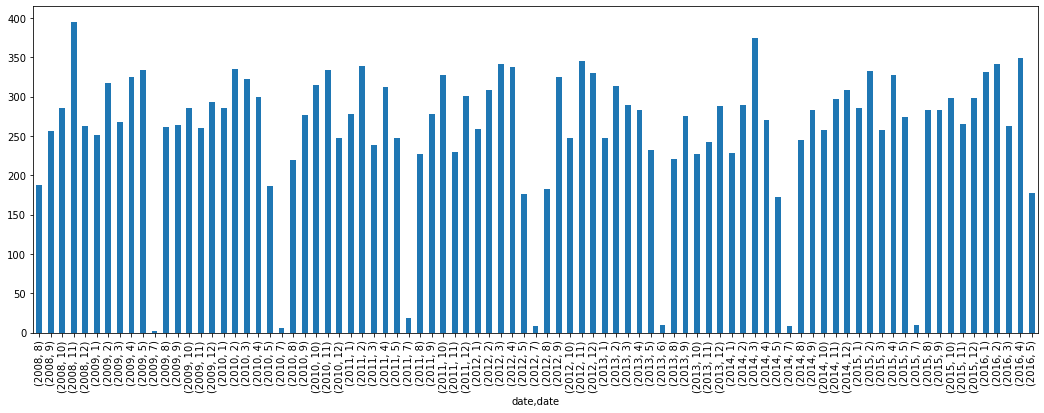

In [40]:
df["date"] = df["date"].astype("datetime64")
df.date.groupby([df["date"].dt.year, df["date"].dt.month]).count().plot(kind="bar", legend=False, figsize=(18, 6))

<AxesSubplot:xlabel='date'>

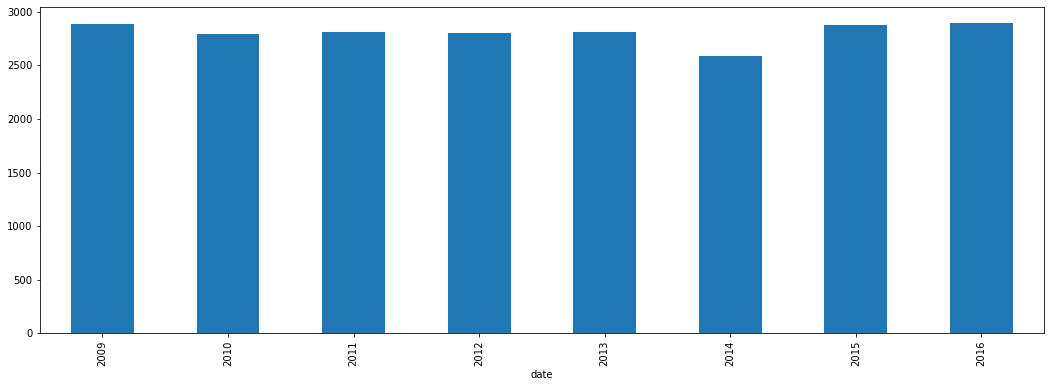

In [37]:
# Group by per season, if month is after June we move it to the next year
season_years = df["date"].dt.year + (df["date"].dt.month>6).astype(int)
df.date.groupby(season_years).count().plot(kind="bar", legend=False, figsize=(18, 6))




In [33]:
df["season"] = season_years
ta_df["date"] = ta_df["date"].astype("datetime64")
ta_df["season"] = ta_df.date.dt.year + (ta_df["date"].dt.month > 6).astype(int)

<AxesSubplot:xlabel='season'>

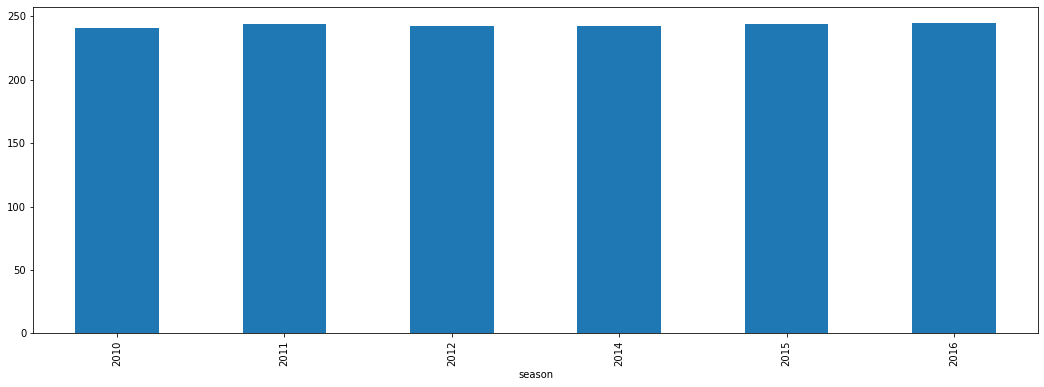

In [36]:
ta_df.season.groupby(ta_df.season).count().plot(kind="bar", legend=False, figsize=(18, 6))

## Join tables on season and team_id, both for home and away teams

In [52]:
df1 = pd.merge(df, ta_df, left_on=["season", "home_team_api_id"], right_on=["season", "team_api_id"], how="inner", suffixes=("_match", "_team"))
df1.columns

Index(['id_match', 'date_match', 'match_api_id', 'home_team_api_id',
       'away_team_api_id', 'win_lose_draw', 'B365H', 'B365D', 'B365A', 'BWH',
       'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'season',
       'id_team', 'team_api_id', 'date_team', 'buildUpPlaySpeed',
       'buildUpPlayPassing', 'chanceCreationPassing', 'chanceCreationCrossing',
       'chanceCreationShooting', 'defencePressure', 'defenceAggression',
       'defenceTeamWidth'],
      dtype='object')

In [56]:
df2 = pd.merge(df1, ta_df, left_on=["season", "away_team_api_id"], right_on=["season", "team_api_id"], how="inner", suffixes=("_H", "_A"))
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15981 entries, 0 to 15980
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id_match                  15981 non-null  int64         
 1   date_match                15981 non-null  datetime64[ns]
 2   match_api_id              15981 non-null  int64         
 3   home_team_api_id          15981 non-null  int64         
 4   away_team_api_id          15981 non-null  int64         
 5   win_lose_draw             15981 non-null  object        
 6   B365H                     15981 non-null  float64       
 7   B365D                     15981 non-null  float64       
 8   B365A                     15981 non-null  float64       
 9   BWH                       15981 non-null  float64       
 10  BWD                       15981 non-null  float64       
 11  BWA                       15981 non-null  float64       
 12  IWH               

In [59]:
df2.describe(include="all")

/var/folders/_w/rydkwfsd5n71v66j4j94xvbc0000gn/T/ipykernel_80222/3774569130.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df2.describe(include="all")
/var/folders/_w/rydkwfsd5n71v66j4j94xvbc0000gn/T/ipykernel_80222/3774569130.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df2.describe(include="all")
/var/folders/_w/rydkwfsd5n71v66j4j94xvbc0000gn/T/ipykernel_80222/3774569130.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence t

,id_match,date_match,match_api_id,home_team_api_id,away_team_api_id,win_lose_draw,B365H,B365D,B365A,BWH,...,team_api_id_A,date,buildUpPlaySpeed_A,buildUpPlayPassing_A,chanceCreationPassing_A,chanceCreationCrossing_A,chanceCreationShooting_A,defencePressure_A,defenceAggression_A,defenceTeamWidth_A
count,15981.00000,15981,1.598100e+04,15981.000000,15981.000000,15981,15981.000000,15981.000000,15981.000000,15981.000000,...,15981.000000,15981,15981.000000,15981.000000,15981.000000,15981.000000,15981.000000,15981.000000,15981.000000,15981.000000
unique,NaN,1180,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,...,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2010-09-11 00:00:00,NaN,NaN,NaN,H,NaN,NaN,NaN,NaN,...,NaN,2010-02-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,47,NaN,NaN,NaN,7369,NaN,NaN,NaN,NaN,...,NaN,2793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,2009-07-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2010-02-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2016-05-17 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2015-09-10 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,11991.36387,NaN,1.285533e+06,9978.755209,9960.034666,NaN,2.661016,3.877895,4.721542,2.589340,...,9960.034666,NaN,52.909455,47.858582,52.531944,54.303986,54.102246,46.339466,49.793380,52.182154
std,7217.60445,NaN,4.855301e+05,12538.458088,12428.372396,NaN,1.869645,1.180286,3.891346,1.696014,...,12428.372396,NaN,11.987243,11.374362,10.702289,11.047534,10.597839,10.466065,10.009094,9.865081
min,307.00000,NaN,6.538650e+05,1773.000000,1773.000000,NaN,1.040000,1.530000,1.080000,1.030000,...,1773.000000,NaN,20.000000,20.000000,21.000000,20.000000,22.000000,23.000000,24.000000,30.000000
25%,5829.00000,NaN,8.401360e+05,8533.000000,8533.000000,NaN,1.670000,3.300000,2.500000,1.650000,...,8533.000000,NaN,45.000000,39.000000,47.000000,48.000000,48.000000,39.000000,44.000000,47.000000


<AxesSubplot:>

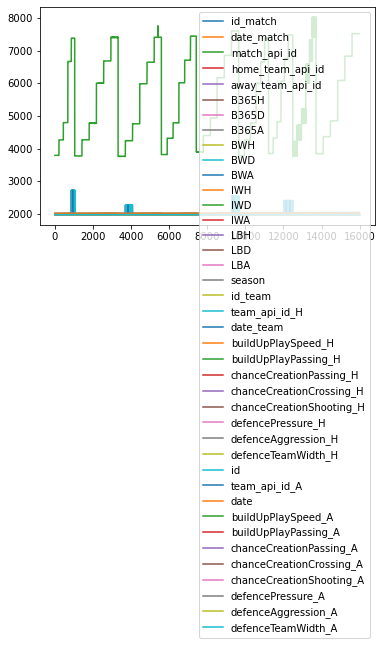

In [57]:
df2.plot()